In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics import accuracy_score

In [3]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-30-longtogeny_v2_males_raw_usage_df_beh_age.parquet').groupby(['age','mouse']).mean()
f_df =  pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-30-longtogeny_v2_females_raw_usage_df_beh_age.parquet').groupby(['age','mouse']).mean()
f_df = f_df.query('mouse!="F4_03"')
m_df['sex'] = 'm'
m_df.set_index('sex', inplace = True, append=True)
f_df['sex'] = 'f'
f_df.set_index('sex', inplace = True, append=True)
# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])
#combined_df.set_index('sex', inplace=True, append=True)

In [7]:
format_plots()

In [4]:
## identity decoder for raw data

In [5]:
# Parameters
N_SPLIT = 5
N_REP = 20
N_SHUFFLE = 1
WINDOW_SIZE = 8

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='linear'))
])

# Function to perform rolling window analysis using a pipeline
def rolling_window_classification(df, pipeline, window_size=8):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    for i in tqdm(range(len(ages) - window_size + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)
        
        for sex in np.unique(window_data.index.get_level_values('sex')):
            sex_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_sex = sex_data.values
            y_sex = sex_data.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                # do age-normalization with proper cross validation
                y_pred = cross_val_predict(pipeline, X_sex, y_sex, cv=skf, n_jobs=-1)
                results.append((center_age, accuracy_score(y_sex,y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_shuffled = np.random.permutation(y_sex)
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                y_pred_shuff = cross_val_predict(pipeline, X_sex, y_shuffled, cv=skf, n_jobs=-1)
                shuffle_results.append((center_age, accuracy_score(y_shuffled,y_pred_shuff), sex))  
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE)
results_df = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress:   0%|                                                                                                                                          | 0/39 [00:00<?, ?it/s]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

Rolling Window Classification Progress:   3%|███▎                                                                                                                              | 1/39 [00:07<04:30,  7.13s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3

Rolling Window Classification Progress:   5%|██████▋                                                                                                                           | 2/39 [00:07<02:04,  3.37s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3

Rolling Window Classification Progress:   8%|██████████                                                                                                                        | 3/39 [00:08<01:17,  2.17s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  10%|█████████████▎                                                                                         

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  13%|████████████████▋                                                                                      

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  49%|██████████████████████████████████████████████████████████████▊                                                                  | 19/39 [00:19<00:13,  1.43it/s]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  51%|██████████████████████████████████████████████████████████████████▏                                    

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 28/39 [00:25<00:07,  1.42it/s]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 29/39 [00:26<00:06,  1.47it/s]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

In [6]:
## identity decoder for demeaned data

In [7]:
# Function to de-mean based on the train set
def demean_by_age(train_data, test_data):
    # Group by 'age' in the training data and calculate mean per age
    age_mean_train = train_data.groupby(level='age').mean()
    
    # Subtract train set means from both the training and test sets
    train_demeaned = train_data.sub(age_mean_train, level='age')
    test_demeaned = test_data.sub(age_mean_train, level='age', fill_value=0)
    
    return train_demeaned, test_demeaned

# Function to perform rolling window analysis using a pipeline
def rolling_window_classification(df, pipeline, window_size=8):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    for i in tqdm(range(len(ages) - window_size + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)
        
        for sex in np.unique(window_data.index.get_level_values('sex')):
            sex_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_sex = sex_data.values
            y_sex = sex_data.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                for train_idx, test_idx in skf.split(X_sex, y_sex):
                    X_train, X_test = X_sex[train_idx], X_sex[test_idx]
                    y_train, y_test = y_sex[train_idx], y_sex[test_idx]
                    
                    # Demean the training and test sets using train data
                    train_data = sex_data.iloc[train_idx]
                    test_data = sex_data.iloc[test_idx]
                    train_demeaned, test_demeaned = demean_by_age(train_data, test_data)
                    
                    # Perform scaling and classification
                    pipeline.fit(train_demeaned.values, y_train)
                    y_pred = pipeline.predict(test_demeaned.values)
                    results.append((center_age, accuracy_score(y_test, y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_shuffled = np.random.permutation(y_sex)
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                for train_idx, test_idx in skf.split(X_sex, y_shuffled):
                    X_train, X_test = X_sex[train_idx], X_sex[test_idx]
                    y_train_shuff, y_test_shuff = y_shuffled[train_idx], y_shuffled[test_idx]
                    
                    # Demean the training and test sets using train data
                    train_data = sex_data.iloc[train_idx]
                    test_data = sex_data.iloc[test_idx]
                    train_demeaned, test_demeaned = demean_by_age(train_data, test_data)
                    
                    # Perform scaling and classification
                    pipeline.fit(train_demeaned.values, y_train_shuff)
                    y_pred_shuff = pipeline.predict(test_demeaned.values)
                    shuffle_results.append((center_age, accuracy_score(y_test_shuff, y_pred_shuff), sex))
                    
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE)
results_df_demean = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df_demean = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress:   0%|                                                                                                                                          | 0/39 [00:00<?, ?it/s]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:   3%|███▎                                                                                                                              | 1/39 [00:01<01:12,  1.91s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  33%|███████████████████████████████████████████                                                                                      | 13/39 [00:23<00:45,  1.77s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  36%|██████████████████████████████████████████████▎                                                                                  | 14/39 [00:24<00:43,  1.75s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 31/39 [00:55<00:14,  1.77s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

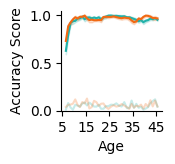

In [8]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2), legend=False)

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1.05])
plt.xticks([5,15,25,35,45])
sns.despine()
plt.show()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

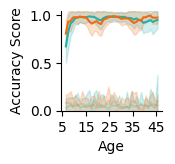

In [9]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df_demean, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df_demean, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2), legend=False)

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1.05])
plt.xticks([5,15,25,35,45])
sns.despine()
plt.show()

In [10]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '09_16_indv_decoder_longv2_demean_bioage.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

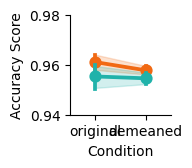

In [11]:
# Combine the two DataFrames for comparison
results_df['condition'] = 'original'
results_df_demean['condition'] = 'demeaned'

# Concatenate the two dataframes
compare_df = pd.concat([results_df, results_df_demean])

# Group by 'sex' and 'condition' to calculate mean and SD
accuracy_stats = compare_df.groupby(['sex', 'condition'])['accuracy'].agg(['mean', 'std']).reset_index()

# Define custom palette where males are teal and females are orange
custom_palette = {'m': '#20B2AA', 'f': '#f16913'}  # Teal for males, Orange for females

# Plot the box plot for overall accuracy comparison, without legend and outliers
plt.figure(figsize=(1.3, 1.3))
#sns.boxplot(data=compare_df, x='condition', y='accuracy', hue='sex', palette=custom_palette, showfliers=False)
sns.lineplot(data=compare_df, x='condition', y='accuracy', hue='sex',palette=custom_palette)
sns.pointplot(data=compare_df, x='condition', y='accuracy', hue='sex',palette=custom_palette)


# Remove the legend
plt.legend([], [], frameon=False)

# Customize plot
plt.ylim([0.94,0.98])
plt.ylabel('Accuracy Score')
plt.xlabel('Condition')
sns.despine()
plt.show()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '09_16_indv_decoder_longv2_demean_bioage_comparison.pdf')

In [31]:
## last data point prediction

In [32]:
## for raw data

In [4]:
# Parameters
N_SPLIT = 5
N_REP = 20
N_SHUFFLE = 100
WINDOW_SIZE = 8
N_TEST_SESSIONS = 8

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='linear'))
])

def rolling_window_classification(df, pipeline, window_size=8, n_test_sessions=2):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    # Identify the last n sessions for testing
    test_sessions = ages[-n_test_sessions:]
    # Get test data (always the same last n sessions)
    test_data = df.loc[df.index.get_level_values('age').isin(test_sessions)]
    
    for i in tqdm(range(len(ages) - window_size - n_test_sessions + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)

        for sex in np.unique(window_data.index.get_level_values('sex')):
            train_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_train = train_data.values
            y_train = train_data.index.get_level_values('mouse')
            
            test_data_sex = test_data[test_data.index.get_level_values('sex') == sex]
            X_test = test_data_sex.values
            y_test = test_data_sex.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                results.append((center_age, accuracy_score(y_test, y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_train_shuffled = np.random.permutation(y_train)
                y_test_shuffled = np.random.permutation(y_test)
                pipeline.fit(X_train, y_train_shuffled)
                y_pred_shuff = pipeline.predict(X_test)
                shuffle_results.append((center_age, accuracy_score(y_test_shuffled, y_pred_shuff), sex))
    
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE, n_test_sessions=N_TEST_SESSIONS)
results_df = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress: 100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:46<00:00,  1.52s/it]


In [34]:
## for demeaned data

In [35]:
# Function to de-mean based on the train set
#def demean_by_age(train_data, test_data):
    # Group by 'age' in the training data and calculate mean per age
   # age_mean_train = train_data.groupby(level='age').mean()
    
    # Subtract train set means from both the training and test sets
  #  train_demeaned = train_data.sub(age_mean_train, level='age')
 #   test_demeaned = test_data.sub(age_mean_train, level='age', fill_value=0)
    
#    return train_demeaned, test_demeaned

def demean_by_age(train_data, test_data):
    # Group by 'age' in the training data and calculate mean per age
    age_mean_train = train_data.groupby(level='age').mean()
    age_mean_test = test_data.groupby(level='age').mean()
    
    # Subtract train set means from both the training and test sets
    train_demeaned = train_data.sub(age_mean_train, level='age')
    test_demeaned = test_data.sub(age_mean_test, level='age', fill_value=0)
    
    return train_demeaned, test_demeaned

# Function to perform rolling window classification with fixed test data
def rolling_window_classification(df, pipeline, window_size=8, n_test_sessions=2):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()

    # Identify the last n sessions for testing
    test_sessions = ages[-n_test_sessions:]
    # Get test data (always the same last n sessions)
    test_data = df.loc[df.index.get_level_values('age').isin(test_sessions)]

    # Loop over the rolling window for the training data
    for i in tqdm(range(len(ages) - window_size - n_test_sessions + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)

        # Loop over sexes after defining the window
        for sex in np.unique(test_data.index.get_level_values('sex')):
            test_data_sex = test_data[test_data.index.get_level_values('sex') == sex]
            train_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_train = train_data.values
            y_train = train_data.index.get_level_values('mouse')

            # Demean the training and test sets using train data
            train_demeaned, test_demeaned = demean_by_age(train_data, test_data_sex)

            # Original classification
            for j in range(N_REP):
                pipeline.fit(train_demeaned.values, y_train)
                y_pred = pipeline.predict(test_demeaned.values)
                results.append((center_age, accuracy_score(test_data_sex.index.get_level_values('mouse'), y_pred), sex))

            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_train_shuffled = np.random.permutation(y_train)
                y_test_shuffled = np.random.permutation(test_data_sex.index.get_level_values('mouse'))
                pipeline.fit(train_demeaned.values, y_train_shuffled)
                y_pred_shuff = pipeline.predict(test_demeaned.values)
                shuffle_results.append((center_age, accuracy_score(y_test_shuffled, y_pred_shuff), sex))

    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE, n_test_sessions=N_TEST_SESSIONS)
results_df_demeaned = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df_demeaned = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:52<00:00,  1.68s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

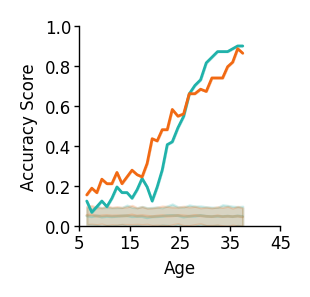

In [8]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2), legend=False)

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1])
plt.xticks([5,15,25,35,45])
sns.despine()
plt.show()

In [9]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '09_16_indv_decoder_longv2_TEST_LAST_POINT_bioage.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

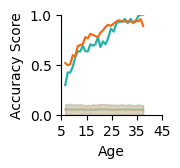

In [37]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df_demeaned, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df_demeaned, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2), legend=False)

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1])
plt.xticks([5,15,25,35,45])
sns.despine()
plt.show()

In [38]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '09_16_indv_decoder_longv2_TEST_LAST_POINT_demean_bioage.pdf')